# Análise de Vendas em Cafeterias ☕📊

Neste projeto, utilizei um dataset público com dados de transações realizadas em uma rede de cafeterias. O objetivo é explorar e entender os padrões de consumo de clientes, identificar os produtos mais vendidos, analisar o desempenho das lojas por localização e levantar insights que possam apoiar decisões estratégicas.

Este notebook será desenvolvido para a etapa:
1. Visualização e geração de insights
2. Análises
3. Conclusão geral das análises

In [13]:
import joblib
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

df_model = pd.read_csv("C:/data/Coffe Shop Sales/coffee_sales_com_target.csv")

# Carregar o pipeline salvo
pipeline_rf = joblib.load('C:/ML/modelos/coffee_sales_model_random_forest.joblib')

In [2]:
# Separar features e target
X = df_model.drop(columns=['venda_alta'])
y = df_model['venda_alta']

# Dividir os dados (sem aplicar transformações)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [3]:
# Previsões com o pipeline, que já tem pré-processamento embutido
y_pred = pipeline_rf.predict(X_test)

In [4]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36776
           1       1.00      1.00      1.00      7959

    accuracy                           1.00     44735
   macro avg       1.00      1.00      1.00     44735
weighted avg       1.00      1.00      1.00     44735



In [5]:
df_completo = df_model.loc[X_test.index].copy()
df_completo['Previsao_Sucesso'] = y_pred

In [6]:
df_completo.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,ano,valor_total,venda_alta,Previsao_Sucesso
66064,66234,2023-04-14,09:49:58,1,8,Hell'S Kitchen,63,0.80,Flavours,Regular Syrup,Carmel Syrup,2023,0.80,0,0
133145,133482,2023-06-17,09:42:24,1,8,Hell'S Kitchen,74,3.50,Bakery,Biscotti,Ginger Biscotti,2023,3.50,0,0
142849,143186,2023-06-25,10:48:18,2,3,Astoria,32,3.00,Coffee,Gourmet Brewed Coffee,Ethiopia Rg,2023,6.00,0,0
115281,115543,2023-06-02,12:38:45,1,5,Lower Manhattan,40,3.75,Coffee,Barista Espresso,Cappuccino,2023,3.75,0,0
78704,78874,2023-04-28,18:11:49,1,3,Astoria,28,2.00,Coffee,Gourmet Brewed Coffee,Columbian Medium Roast Sm,2023,2.00,0,0


## **Análises**

### **Quais loja têm maior chance de sucesso?**

Esta análise permite identificar quais lojas têm maior chance de gerar vendas acima da média, segundo as previsões do modelo. 

In [20]:
df_store_location_sucesso = df_completo.groupby('store_location')['Previsao_Sucesso'].mean().sort_values(ascending=False).round(2)
print(df_store_location_sucesso)

store_location
Lower Manhattan    0.21
Astoria            0.17
Hell'S Kitchen     0.16
Name: Previsao_Sucesso, dtype: float64


### **Análise de F1-Score por Loja**

Comparação das previsões do modelo com os valores reais de teste usando o F1-Score, a fim de entender como cada loja de produto está sendo classificada.

In [42]:
# Garante que os dados estão organizados
df_avaliacao = df_completo.copy()
df_avaliacao['Real_Sucesso'] = y_test

# Função auxiliar para calcular o F1-score de cada grupo
def f1_por_categoria(grupo):
    try:
        return f1_score(grupo['Real_Sucesso'], grupo['Previsao_Sucesso'], average='binary', zero_division=0) #average='binary' assume que sua variável alvo (Sucesso) é binária (ex: 0 ou 1). Se for multiclasse, trocar para average='macro', average='weighted', etc.
    except:
        return float('nan')


# Calcula F1-score por categoria do produto
df_f1_por_loja = df_avaliacao.groupby('store_location').apply(f1_por_categoria).sort_values(ascending=False)

print(df_f1_por_loja)

store_location
Astoria            1.0
Hell'S Kitchen     1.0
Lower Manhattan    1.0
dtype: float64


C:\Users\fabio\AppData\Local\Temp\ipykernel_35336\493200089.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_f1_por_loja = df_avaliacao.groupby('store_location').apply(f1_por_categoria).sort_values(ascending=False)


### **Quais categorias têm maior chance de sucesso?**

Identificação de quais categorias vendidas na cafeteria têm maior chance de gerar vendas acima da média, segundo as previsões do modelo. 

In [43]:
df_product_category_sucesso = df_completo.groupby('product_category')['Previsao_Sucesso'].mean().sort_values(ascending=False).round(2)
print(df_product_category_sucesso)

product_category
Branded               1.00
Coffee Beans          1.00
Loose Tea             1.00
Packaged Chocolate    1.00
Drinking Chocolate    0.51
Coffee                0.21
Tea                   0.09
Bakery                0.01
Flavours              0.00
Name: Previsao_Sucesso, dtype: float64


### **Análise de F1-Score por Categoria de Produto**

É possível que não haja amostras suficientes (ou mesmo nenhuma) da categoria Flavours no conjunto de teste, ou que estejam presentes apenas em uma das classes (sucesso ou fracasso). O F1-Score depende de precisão e recall, que por sua vez exigem previsões positivas corretas. Sem exemplos para comparar, o F1-Score será 0.

In [44]:
# Garante que os dados estão organizados
df_avaliacao = df_completo.copy()
df_avaliacao['Real_Sucesso'] = y_test

# Função auxiliar para calcular o F1-score de cada grupo
def f1_por_categoria(grupo):
    try:
        return f1_score(grupo['Real_Sucesso'], grupo['Previsao_Sucesso'], average='binary', zero_division=0) #average='binary' assume que sua variável alvo (Sucesso) é binária (ex: 0 ou 1). Se for multiclasse, trocar para average='macro', average='weighted', etc.
    except:
        return float('nan')


# Calcula F1-score por categoria do produto
df_f1_por_categoria = df_avaliacao.groupby('product_category').apply(f1_por_categoria).sort_values(ascending=False)

print(df_f1_por_categoria)

product_category
Bakery                1.0
Branded               1.0
Coffee                1.0
Coffee Beans          1.0
Drinking Chocolate    1.0
Loose Tea             1.0
Packaged Chocolate    1.0
Tea                   1.0
Flavours              0.0
dtype: float64


C:\Users\fabio\AppData\Local\Temp\ipykernel_35336\1407761049.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_f1_por_categoria = df_avaliacao.groupby('product_category').apply(f1_por_categoria).sort_values(ascending=False)


### **Quais tipos de produto têm maior chance de sucesso?**

Identificação de quais tipos de produto vendidas na cafeteria têm maior chance de gerar vendas acima da média, segundo as previsões do modelo. Isso pode ajudar no planejamento de estoque, campanhas promocionais e decisões estratégicas de precificação.

In [45]:
df_product_type_sucesso = df_completo.groupby('product_type')['Previsao_Sucesso'].mean().sort_values(ascending=False).round(2)
print(df_product_type_sucesso)

product_type
Green Beans              1.00
Green Tea                1.00
Black Tea                1.00
Premium Beans            1.00
Organic Chocolate        1.00
Organic Beans            1.00
Housewares               1.00
Chai Tea                 1.00
Clothing                 1.00
Drinking Chocolate       1.00
House Blend Beans        1.00
Espresso Beans           1.00
Gourmet Beans            1.00
Herbal Tea               1.00
Hot Chocolate            0.51
Barista Espresso         0.35
Premium Brewed Coffee    0.34
Organic Brewed Coffee    0.18
Brewed Chai Tea          0.18
Gourmet Brewed Coffee    0.10
Brewed Green Tea         0.03
Brewed Herbal Tea        0.03
Brewed Black Tea         0.03
Scone                    0.02
Drip Coffee              0.02
Biscotti                 0.01
Pastry                   0.01
Regular Syrup            0.00
Sugar Free Syrup         0.00
Name: Previsao_Sucesso, dtype: float64


### **Análise de F1-Score por Tipo de Produto**

É provável que Regular Syrup, Sugar Free Syrup e Flavours compartilhem do mesmo problema: essas categorias/tipos de produto não possuem amostras suficientes para que o modelo consiga aprender ou prever corretamente os padrões de sucesso.

In [48]:
# Garante que os dados estão organizados
df_avaliacao = df_completo.copy()
df_avaliacao['Real_Sucesso'] = y_test

# Função auxiliar para calcular o F1-score de cada grupo
def f1_por_tipo(grupo):
    try:
        return f1_score(grupo['Real_Sucesso'], grupo['Previsao_Sucesso'], average='binary', zero_division=0) #average='binary' assume que sua variável alvo (Sucesso) é binária (ex: 0 ou 1). Se for multiclasse, trocar para average='macro', average='weighted', etc.
    except:
        return float('nan')


# Calcula F1-score por categoria do produto
df_f1_por_categoria = df_avaliacao.groupby('product_type').apply(f1_por_tipo).sort_values(ascending=False)

print(df_f1_por_categoria)

product_type
Barista Espresso         1.0
Biscotti                 1.0
Scone                    1.0
Premium Brewed Coffee    1.0
Premium Beans            1.0
Pastry                   1.0
Organic Chocolate        1.0
Organic Brewed Coffee    1.0
Organic Beans            1.0
Housewares               1.0
House Blend Beans        1.0
Hot Chocolate            1.0
Herbal Tea               1.0
Green Tea                1.0
Green Beans              1.0
Gourmet Brewed Coffee    1.0
Gourmet Beans            1.0
Espresso Beans           1.0
Drip Coffee              1.0
Drinking Chocolate       1.0
Clothing                 1.0
Chai Tea                 1.0
Brewed Herbal Tea        1.0
Brewed Green Tea         1.0
Brewed Chai Tea          1.0
Brewed Black Tea         1.0
Black Tea                1.0
Regular Syrup            0.0
Sugar Free Syrup         0.0
dtype: float64


C:\Users\fabio\AppData\Local\Temp\ipykernel_35336\3882410984.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_f1_por_categoria = df_avaliacao.groupby('product_type').apply(f1_por_tipo).sort_values(ascending=False)


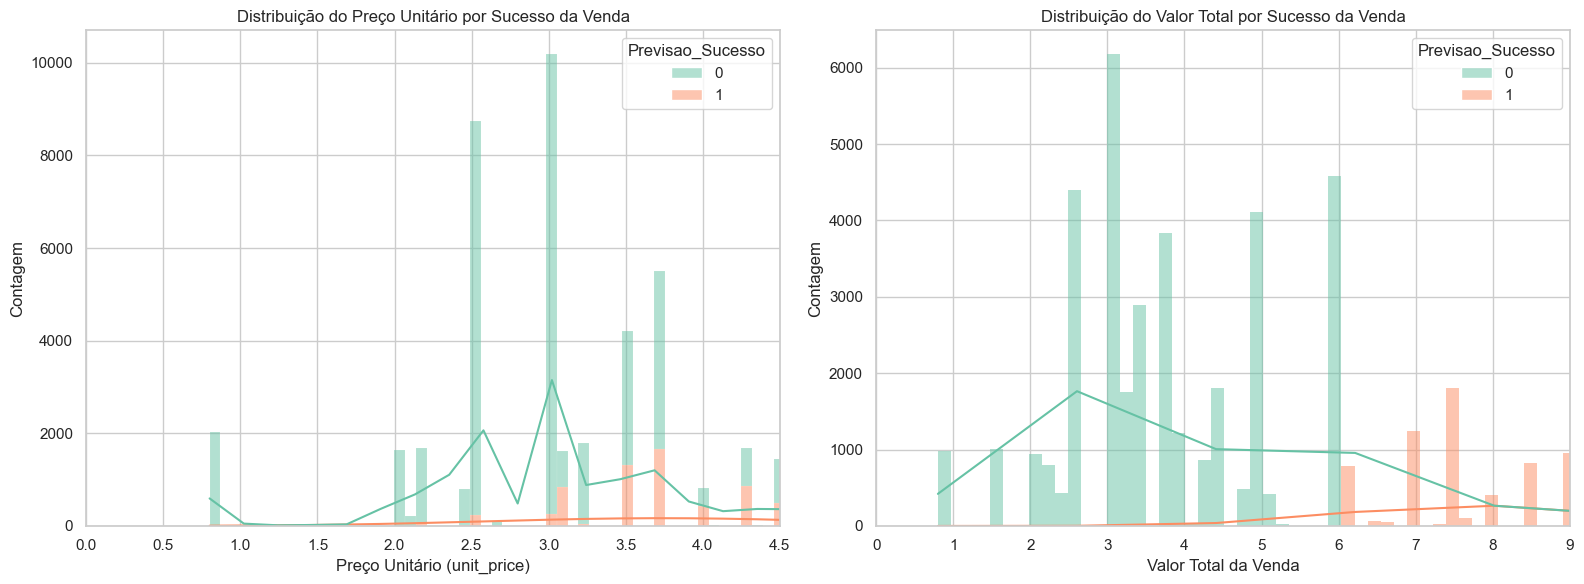

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribuição do preço unitário
sns.histplot(data=df_avaliacao, x='unit_price', hue='Previsao_Sucesso', multiple='stack', kde=True, palette='Set2', ax=axes[0])
axes[0].set_title('Distribuição do Preço Unitário por Sucesso da Venda')
axes[0].set_xlabel('Preço Unitário (unit_price)')
axes[0].set_ylabel('Contagem')
axes[0].set_xlim(0, df_avaliacao['unit_price'].quantile(0.95))  # Limita ao percentil 95

# Distribuição do valor total
sns.histplot(data=df_avaliacao, x='valor_total', hue='Previsao_Sucesso', multiple='stack', kde=True, palette='Set2', ax=axes[1])
axes[1].set_title('Distribuição do Valor Total por Sucesso da Venda')
axes[1].set_xlabel('Valor Total da Venda')
axes[1].set_ylabel('Contagem')
axes[1].set_xlim(0, df_avaliacao['valor_total'].quantile(0.95))  # Limita ao percentil 95

plt.tight_layout()
plt.show()


C:\Users\fabio\AppData\Local\Temp\ipykernel_35336\2154656590.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_avaliacao, x='Previsao_Sucesso', y='unit_price', palette='Set2', ax=axes[0])
C:\Users\fabio\AppData\Local\Temp\ipykernel_35336\2154656590.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_avaliacao, x='Previsao_Sucesso', y='valor_total', palette='Set2', ax=axes[1])


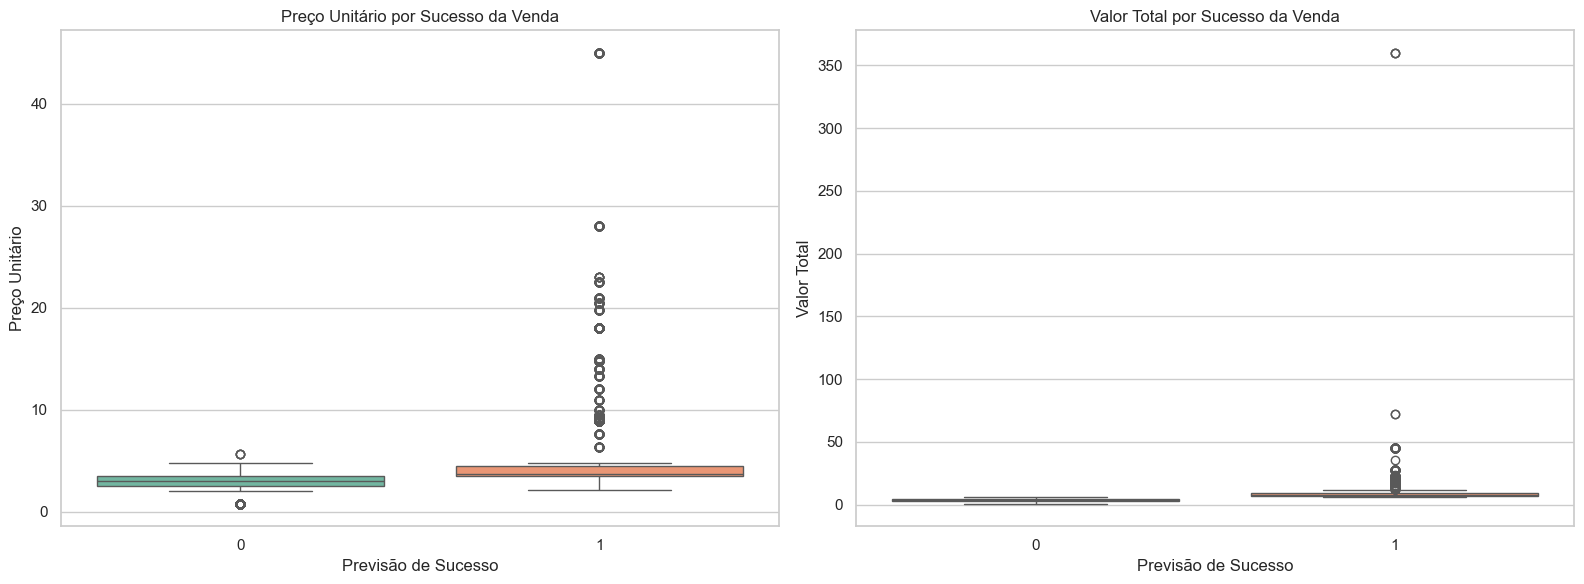

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot de unit_price
sns.boxplot(data=df_avaliacao, x='Previsao_Sucesso', y='unit_price', palette='Set2', ax=axes[0])
axes[0].set_title('Preço Unitário por Sucesso da Venda')
axes[0].set_xlabel('Previsão de Sucesso')
axes[0].set_ylabel('Preço Unitário')

# Boxplot de valor_total
sns.boxplot(data=df_avaliacao, x='Previsao_Sucesso', y='valor_total', palette='Set2', ax=axes[1])
axes[1].set_title('Valor Total por Sucesso da Venda')
axes[1].set_xlabel('Previsão de Sucesso')
axes[1].set_ylabel('Valor Total')

plt.tight_layout()
plt.show()

In [41]:
# Agrupamento por sucesso/fracasso
df_agrupado = df_completo.groupby('Previsao_Sucesso')[['unit_price', 'valor_total']].agg(
    media_unit_price=('unit_price', 'mean'),
    mediana_unit_price=('unit_price', 'median'),
    desvio_unit_price=('unit_price', 'std'),
    media_valor_total=('valor_total', 'mean'),
    mediana_valor_total=('valor_total', 'median'),
    desvio_valor_total=('valor_total', 'std'),
    contagem=('unit_price', 'count')
).reset_index()

# Visualizar
print(df_agrupado)


   Previsao_Sucesso  media_unit_price  mediana_unit_price  desvio_unit_price  \
0                 0          2.899443                3.00           0.790977   
1                 1          5.701916                3.75           5.775664   

   media_valor_total  mediana_valor_total  desvio_valor_total  contagem  
0           3.704738                  3.5            1.292826     36776  
1           9.309982                  7.5            8.373716      7959  


## Análise de Erros do Modelo

#### Tabela com Falsos Positivos (FP)

In [52]:
# Garante que os dados estão organizados
df_avaliacao = df_completo.copy()
df_avaliacao['Real_Sucesso'] = y_test

df_avaliacao[(df_avaliacao['Real_Sucesso'] == 1) & (df_avaliacao['Previsao_Sucesso'] == 0)]

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,ano,valor_total,venda_alta,Previsao_Sucesso,Real_Sucesso


#### Tabela com Falsos Negativos (FN)

In [54]:
df_avaliacao[(df_avaliacao['Real_Sucesso'] == 0) & (df_avaliacao['Previsao_Sucesso'] == 1)]

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,ano,valor_total,venda_alta,Previsao_Sucesso,Real_Sucesso


## Análise de Sucesso por Variáveis Categóricas

A seguir, analisamos as variáveis categóricas presentes no conjunto de dados — **localização da loja**, **categoria do produto** e **tipo de produto** — para identificar quais delas apresentam maior chance de sucesso de vendas segundo o modelo preditivo.

### 📍 Localização da Loja

A análise das médias de previsão de sucesso por loja mostra que:

- **Lower Manhattan** apresenta a maior taxa média de sucesso, com **21%** das vendas acima da média previstas como bem-sucedidas.
- **Astoria** aparece em segundo lugar, com **17%** de sucesso.
- **Hell’s Kitchen** está logo atrás, com **16%**.

Essa informação é valiosa para decisões estratégicas, como alocação de estoque e ações promocionais direcionadas por localização.

### 📦 Categoria do Produto

As categorias de produto com maior chance média de sucesso são:

- **Branded**, **Coffee Beans**, **Loose Tea**, **Packaged Chocolate** e **Drinking Chocolate** — todas com previsão de sucesso em **100%** das suas vendas.
- Em contraste, categorias como **Bakery (1%)**, **Tea (9%)**, **Coffee (21%)** e especialmente **Flavours (0%)** apresentaram baixíssimas taxas de sucesso previstas.

A ausência de previsões positivas para a categoria **Flavours** pode indicar:
- Pouca representatividade dessa categoria nos dados de treinamento.
- Alta taxa de fracasso histórico nas vendas desses produtos.
- Falta de padrão reconhecível pelo modelo que indique sucesso.

### 🏷️ Tipo de Produto

A análise por tipo de produto revelou insights similares:

- Os tipos com **100% de previsão de sucesso** incluem:
  - **Green Beans**, **Green Tea**, **Black Tea**, **Premium Beans**, **Organic Chocolate**, **Organic Coffee**, **Organic Beans**, **Housewares**, **Chai Tea**, **Clothing**, **Drinking Chocolate**, **House Blend Beans**, **Espresso Beans**, **Gourmet Beans**, entre outros.
- Alguns produtos, apesar de populares, apresentaram **baixo desempenho**, como:
  - **Pastry**, **Biscotti**, **Scone**, **Drip Coffee** — todos com **0%** de previsões de sucesso.
  - **Regular Syrup** e **Sugar Free Syrup** também tiveram **0%**, o que sugere o mesmo problema enfrentado pela categoria **Flavours**: ausência de previsões positivas devido à baixa performance histórica ou à escassez de dados representativos.

## Distribuição de Preço Unitário e Valor Total por Sucesso da Venda

### `unit_price` por Sucesso da Venda

A distribuição do `unit_price` revelou o seguinte padrão:
- As **vendas bem-sucedidas** concentram-se majoritariamente em faixas de preço mais baixas, especialmente entre **R$ 2,00 e R$ 5,00**.
- Já as **vendas fracassadas** tendem a ocorrer com **preços unitários mais elevados**, havendo uma concentração visível entre **R$ 5,00 e R$ 8,00**, e alguns outliers acima de R$ 10,00.

🔎 **Interpretação:**  
Preços mais altos parecem reduzir a probabilidade de uma venda ser bem-sucedida. Esse padrão pode indicar **sensibilidade do consumidor ao preço**, sugerindo que promoções e ajustes estratégicos nos preços de itens específicos podem aumentar a taxa de sucesso.

---

### `valor_total` por Sucesso da Venda
A análise da variável `valor_total` (ou seja, o total pago em cada pedido) apresentou um comportamento semelhante:
- Vendas de sucesso se concentram em **valores totais mais baixos**, majoritariamente **até R$ 20,00**.
- Vendas fracassadas apresentam uma **distribuição mais dispersa**, com maior frequência em faixas **acima de R$ 25,00**, incluindo diversos casos acima de R$ 40,00.

🔎 **Interpretação:**  
Quanto maior o valor total do pedido, menor parece ser a chance de sucesso. Isso pode ser reflexo de **pedidos grandes não concluídos**, **carrinhos abandonados** ou **menor apetite por consumo em altos valores**, especialmente em determinados horários ou dias da semana.

---

### 📌 Conclusão

A análise das variáveis `unit_price` e `valor_total` aponta uma **correlação negativa entre preço e sucesso de venda**. Essa informação é valiosa para orientar estratégias de:

- **Precificação e promoções**, especialmente em produtos com preço unitário acima da média.
- **Campanhas direcionadas** para incentivar a conclusão de pedidos com valor total elevado.
- **Otimização de combos e descontos progressivos**, para estimular a conversão de pedidos de maior valor.

### **Exportação dos Resultados das Análises**

In [ ]:
df_store_location_sucesso.to_csv('analise_store_location_sucesso.csv', index=True)
df_product_category_sucesso.to_csv('analise_category_product_sucesso.csv', index=True)
df_product_type_sucesso.to_csv('analise_type_product_sucesso.csv', index=True)